In [ ]:
# 테스트 데이터 준비

test_file_path = '/home/cnserver/projects/AI/datas/raw/rpm_600/test/600-10 (시작 온도 조금 다름).csv'
df = pd.read_csv(test_file_path)
# 1. 데이터 전처리(위와 똑같은 과정)

In [ ]:
# 1) 칼럼 선택
df_filtered = feature_select(df, ['timestamp', 'accel_x', 'accel_y', 'accel_z'])
df_filtered

,timestamp,accel_x,accel_y,accel_z
0,0,10.07720,-0.174777,0.881066
1,50,10.11790,0.077812,0.492008
2,100,10.13106,-0.029928,0.573411
3,150,10.18613,0.059855,0.527921
4,200,10.15979,-0.001197,0.538695
...,...,...,...,...
35996,1799800,10.18374,0.067038,0.481235
35997,1799850,10.16817,0.004788,0.503979
35998,1799900,10.13585,0.009577,0.520739
35999,1799950,10.22683,0.022745,0.453701


In [ ]:
# 2) outlier 제거
df_cleaned = clean_data(df_filtered, ['temperature'])
df_cleaned

,timestamp,accel_x,accel_y,accel_z
0,0,10.07720,-0.174777,0.524834
1,50,10.11790,0.077812,0.492008
2,100,10.13106,-0.029928,0.573411
3,150,10.18613,0.059855,0.527921
4,200,10.15979,-0.001197,0.538695
...,...,...,...,...
35996,1799800,10.18374,0.067038,0.481235
35997,1799850,10.16817,0.004788,0.503979
35998,1799900,10.13585,0.009577,0.520739
35999,1799950,10.22683,0.022745,0.453701


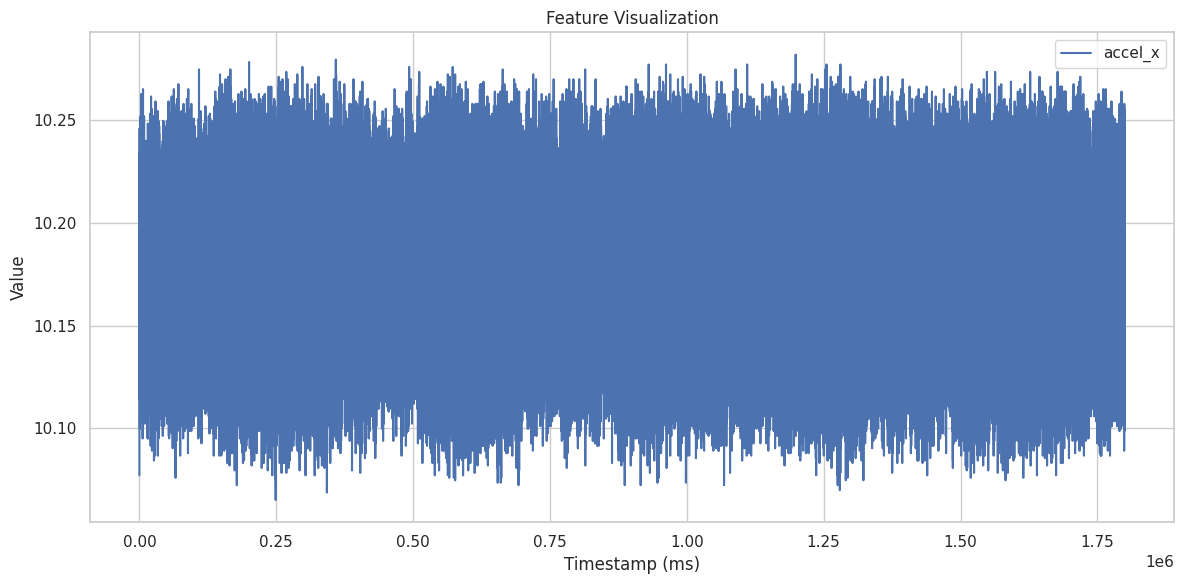

In [ ]:
visualize_features(df_cleaned, features=['accel_x'])

In [ ]:
# 3) 스무딩
df_smoothed = apply_smoothing(df_cleaned, window_size=100, features=['temperature'])
type(df_smoothed)

pandas.core.frame.DataFrame

In [ ]:
# 4) 스케일링
df_scaled, scaler = scale_selected_features_multiple_dfs([df_filtered], ['accel_x', 'accel_y', 'accel_z'], scaler_exist=scaler)
df_scaled=df_scaled[0]
df_scaled

,timestamp,accel_x,accel_y,accel_z
0,0,0.206628,0.024821,1.482560
1,50,0.347118,0.773051,0.537790
2,100,0.392544,0.453899,0.735465
3,150,0.582637,0.719858,0.624999
4,200,0.491716,0.539007,0.651162
...,...,...,...,...
35996,1799800,0.574387,0.741135,0.511629
35997,1799850,0.520642,0.556736,0.566860
35998,1799900,0.409078,0.570922,0.607559
35999,1799950,0.723127,0.609929,0.444767


In [ ]:
# 5) 다운샘플링
downsampled_df = sampler.down_sample_numeric_timestamp(df_scaled)

In [ ]:
# timestamp 삭제
downsampled_df.drop('timestamp', axis=1, inplace=True)

In [ ]:
downsampled_df


,accel_x,accel_y,accel_z
0,0.507025,0.570212,0.685175
1,0.544418,0.601064,0.640844
2,0.544417,0.583333,0.629361
3,0.523964,0.561879,0.660175
4,0.553507,0.584396,0.651890
...,...,...,...
1796,0.539874,0.575886,0.604506
1797,0.542558,0.561170,0.601163
1798,0.532642,0.561879,0.608431
1799,0.547102,0.583865,0.578344


In [ ]:
# 진동 데이터 준비
vibration_data = downsampled_df[['accel_x', 'accel_y', 'accel_z']].copy()
num_samples = len(vibration_data)

# 이상치 주입 (랜덤 구간에 이상치 추가)
np.random.seed(42)  # 재현성을 위해 랜덤 시드 고정
anomaly_indices = np.random.choice(num_samples, size=50, replace=False)  # 이상치 인덱스 랜덤 선택

# 각 축에 이상치 추가
vibration_data.loc[anomaly_indices, 'accel_x'] += np.random.uniform(0.5, 1.5, size=len(anomaly_indices))
vibration_data.loc[anomaly_indices, 'accel_y'] += np.random.uniform(0.5, 1.5, size=len(anomaly_indices))
vibration_data.loc[anomaly_indices, 'accel_z'] += np.random.uniform(0.5, 1.5, size=len(anomaly_indices))

# 레이블 생성
labels = np.zeros(num_samples, dtype=int)  # 모든 데이터를 정상(0)으로 초기화
labels[anomaly_indices] = 1  # 이상치 구간만 1로 설정

# 데이터프레임 생성
anomalous_data = pd.DataFrame({
    'accel_x': vibration_data['accel_x'],
    'accel_y': vibration_data['accel_y'],
    'accel_z': vibration_data['accel_z'],
    'label': labels
})



## 테스트 데이터 시각화

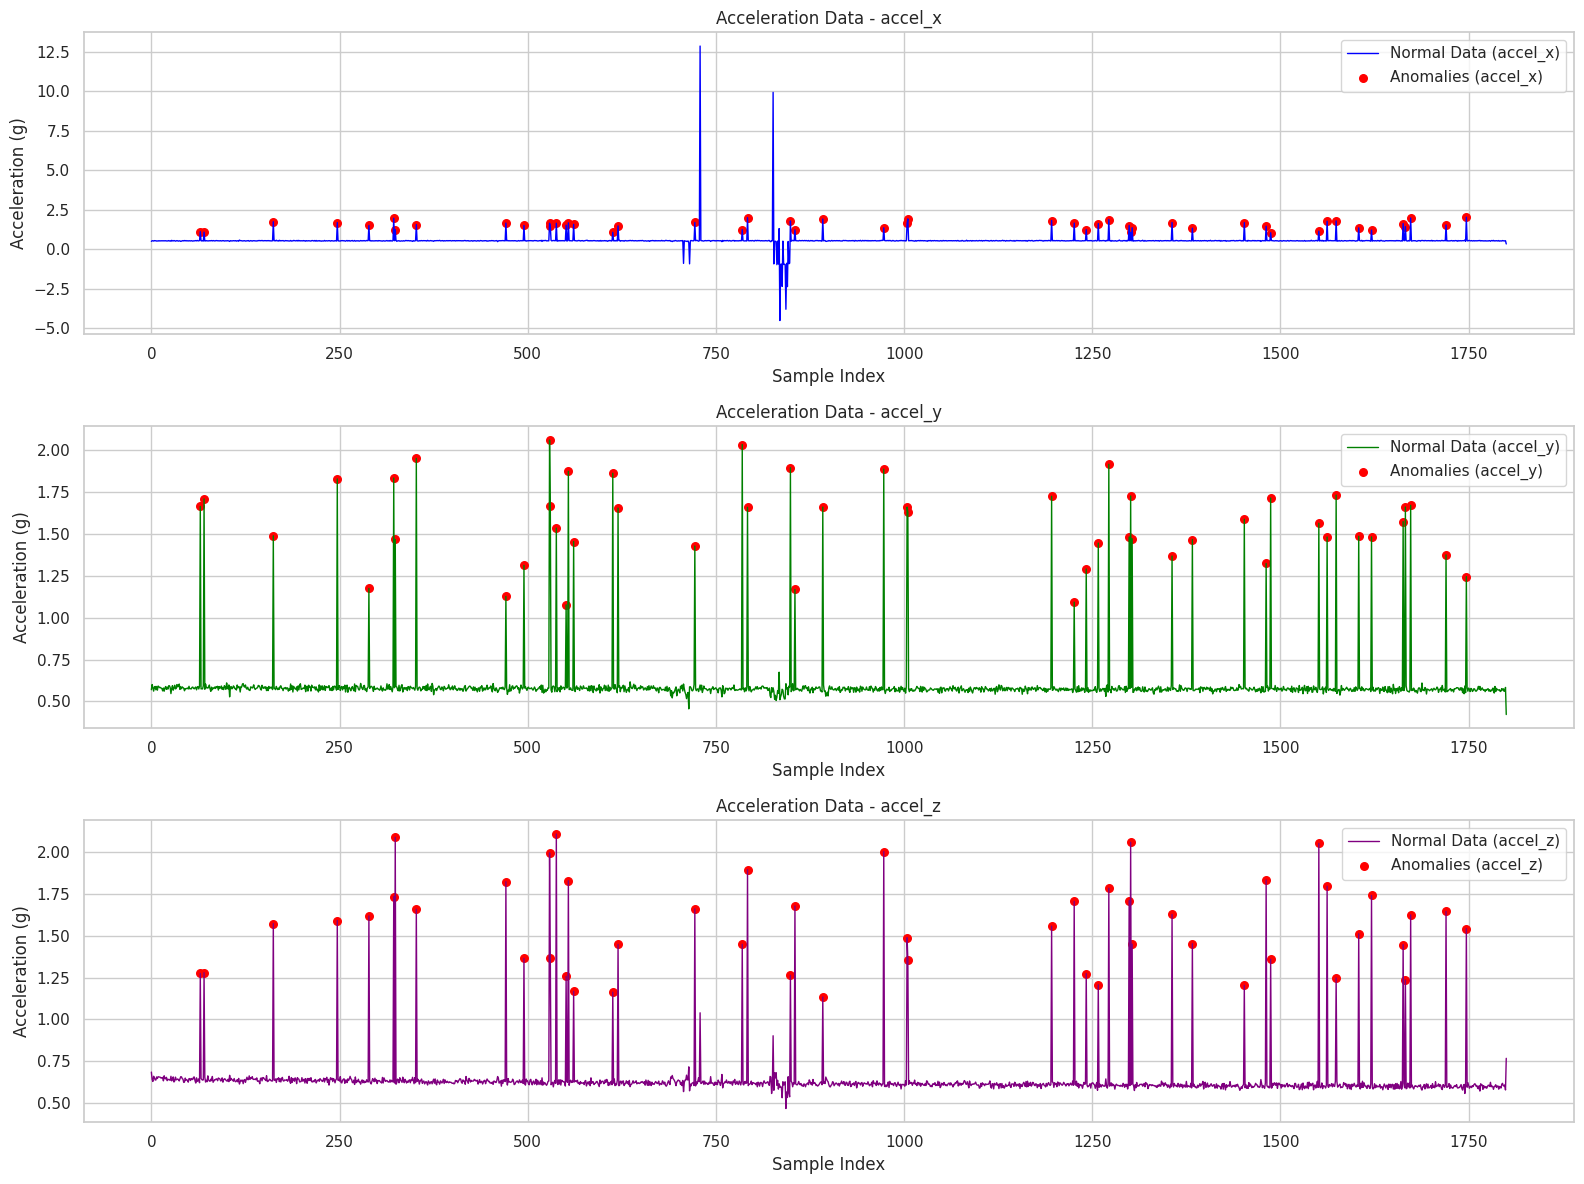

In [ ]:
# 시각화
plt.figure(figsize=(16, 12))

# accel_x 데이터 시각화
plt.subplot(3, 1, 1)  # 3개의 서브플롯 중 첫 번째
plt.plot(anomalous_data.index, anomalous_data['accel_x'], label='Normal Data (accel_x)', color='blue', linewidth=1)
plt.scatter(
    anomalous_data[anomalous_data['label'] == 1].index,
    anomalous_data[anomalous_data['label'] == 1]['accel_x'],
    color='red', label='Anomalies (accel_x)', s=30
)
plt.title('Acceleration Data - accel_x')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)

# accel_y 데이터 시각화
plt.subplot(3, 1, 2)  # 3개의 서브플롯 중 두 번째
plt.plot(anomalous_data.index, anomalous_data['accel_y'], label='Normal Data (accel_y)', color='green', linewidth=1)
plt.scatter(
    anomalous_data[anomalous_data['label'] == 1].index,
    anomalous_data[anomalous_data['label'] == 1]['accel_y'],
    color='red', label='Anomalies (accel_y)', s=30
)
plt.title('Acceleration Data - accel_y')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)

# accel_z 데이터 시각화
plt.subplot(3, 1, 3)  # 3개의 서브플롯 중 세 번째
plt.plot(anomalous_data.index, anomalous_data['accel_z'], label='Normal Data (accel_z)', color='purple', linewidth=1)
plt.scatter(
    anomalous_data[anomalous_data['label'] == 1].index,
    anomalous_data[anomalous_data['label'] == 1]['accel_z'],
    color='red', label='Anomalies (accel_z)', s=30
)
plt.title('Acceleration Data - accel_z')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)

# 그래프 출력
plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()


In [ ]:
# 입력 데이터 (X)와 레이블 (y) 분리
X_test = anomalous_data[['accel_x', 'accel_y', 'accel_z']].values  # 입력 데이터
y_test = anomalous_data['label'].values         # 레이블

# X_test가 2차원이라면 reshape
X_test = X_test.reshape((X_test.shape[0], 3))  # (samples, timesteps, features)


In [ ]:
X_test

array([[0.50702451, 0.57021213, 0.68517455],
       [0.54441836, 0.60106359, 0.64084378],
       [0.54441664, 0.58333309, 0.6293612 ],
       ...,
       [0.53264239, 0.56187904, 0.60843087],
       [0.54710217, 0.58386466, 0.5783436 ],
       [0.34297549, 0.42198636, 0.76744163]])

In [ ]:
sequences = []
window_size = 5
for i in range(len(X_test) - window_size + 1):
    # 윈도우 크기만큼 슬라이싱하여 시퀀스 생성
    sequences.append(X_test[i:i + window_size])

X_test = np.array(sequences)
X_test.shape

(1797, 5, 3)

In [ ]:
X_test

array([[[0.50702451, 0.57021213, 0.68517455],
        [0.54441836, 0.60106359, 0.64084378],
        [0.54441664, 0.58333309, 0.6293612 ],
        [0.52396445, 0.5618786 , 0.66017467],
        [0.55350708, 0.58439638, 0.65189023]],

       [[0.54441836, 0.60106359, 0.64084378],
        [0.54441664, 0.58333309, 0.6293612 ],
        [0.52396445, 0.5618786 , 0.66017467],
        [0.55350708, 0.58439638, 0.65189023],
        [0.54214187, 0.58989312, 0.63822711]],

       [[0.54441664, 0.58333309, 0.6293612 ],
        [0.52396445, 0.5618786 , 0.66017467],
        [0.55350708, 0.58439638, 0.65189023],
        [0.54214187, 0.58989312, 0.63822711],
        [0.54627718, 0.5696804 , 0.63793644]],

       ...,

       [[0.52830342, 0.57677261, 0.61148331],
        [0.55722989, 0.5679072 , 0.61802359],
        [0.53987401, 0.57588601, 0.60450641],
        [0.54255782, 0.56116973, 0.6011633 ],
        [0.53264239, 0.56187904, 0.60843087]],

       [[0.55722989, 0.5679072 , 0.61802359],
        [0.53

In [ ]:
y_test.shape

(1801,)

In [ ]:
# 학습된 모델로 테스트 데이터 재구성
reconstructed = model.predict(X_test)

# 재구성 오차 계산 (MAE: Mean Absolute Error)
reconstruction_error = np.mean(np.abs(X_test - reconstructed), axis=1)

# 이미 설정된 임계값 사용 (학습 시 계산된 threshold)
threshold = 0.1  # 예: 학습 중 설정한 임계값

# 임계값을 초과하면 이상치로 분류
predicted_labels = (reconstruction_error > threshold).any(axis=1).astype(int)


57/57 [==============================] - 0s 2ms/step


In [ ]:
reconstruction_error.shape

(1797, 3)

In [ ]:
predicted_labels.shape

(1797,)

In [ ]:
y_test.shape

(1801,)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 혼동 행렬 출력
print("Confusion Matrix:")
print(confusion_matrix(y_test[4:], predicted_labels))

# 정밀도, 재현율, F1-score 출력
print("\nClassification Report:")
print(classification_report(y_test[4:], predicted_labels))


Confusion Matrix:
[[1530  217]
 [   0   50]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      1747
           1       0.19      1.00      0.32        50

    accuracy                           0.88      1797
   macro avg       0.59      0.94      0.62      1797
weighted avg       0.98      0.88      0.92      1797



In [ ]:
from sklearn.metrics import fbeta_score
# F2 Score 계산
f2_score = fbeta_score(y_test[4:], predicted_labels, beta=2, average='binary')
print(f2_score)

0.5353319057815846


ValueError: x and y must be the same size

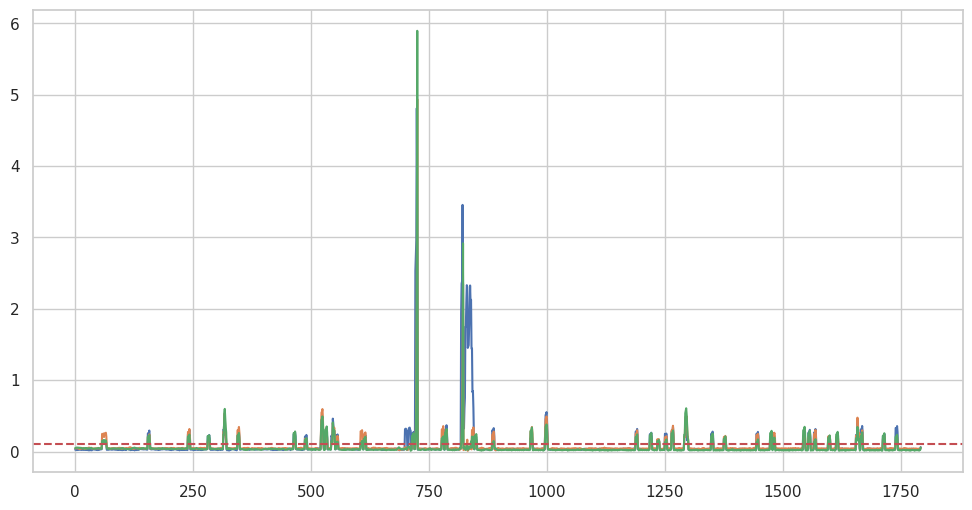

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 재구성 오차 시각화
plt.plot(reconstruction_error[4:], label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (0.1)')
plt.scatter(range(len(reconstruction_error)-4), reconstruction_error[4:], 
            c=predicted_labels, cmap='coolwarm', label='Anomaly (Red)')
plt.title('Reconstruction Error with Anomalies')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error') 
plt.legend()
plt.show()
